In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv
/kaggle/input/random_forest_gs/scikitlearn/default/1/rf_gridsearch_model.pkl


In [ ]:
# train = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
# test = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')

In [ ]:
import pandas as pd
import numpy as np
import zipfile

In [ ]:
# Load train.csv from train.zip
with zipfile.ZipFile('data/train.zip') as z:
    with z.open('train.csv') as f:
        train = pd.read_csv(f)

# Load test.csv from test.zip
with zipfile.ZipFile('data/test.zip') as z:
    with z.open('test.csv') as f:
        test = pd.read_csv(f)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.model_selection import StratifiedKFold
from category_encoders import MEstimateEncoder

#### Data cleaning

In [ ]:
train.head(10)

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
5,5,24,admin.,single,secondary,no,1882,yes,no,cellular,20,apr,1010,3,-1,0,unknown,0
6,6,39,blue-collar,married,secondary,no,0,no,no,telephone,21,nov,90,1,-1,0,unknown,0
7,7,50,admin.,single,secondary,no,1595,no,no,telephone,31,jul,49,25,-1,0,unknown,0
8,8,46,blue-collar,married,primary,no,1463,no,no,cellular,4,aug,50,1,-1,0,unknown,0
9,9,39,management,divorced,tertiary,no,25,yes,no,cellular,8,may,119,1,-1,0,unknown,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


In [ ]:
train.isnull().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [ ]:
test.isnull().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64

In [ ]:
train.describe(include='all')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,750000.000000,750000.000000,750000,750000,750000,750000,750000.000000,750000,750000,750000,750000.000000,750000,750000.000000,750000.000000,750000.000000,750000.000000,750000,750000.000000
unique,NaN,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,NaN
top,NaN,NaN,management,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,NaN
freq,NaN,NaN,175541,480759,401683,737151,NaN,411288,645023,486655,NaN,228411,NaN,NaN,NaN,NaN,672450,NaN
mean,374999.500000,40.926395,NaN,NaN,NaN,NaN,1204.067397,NaN,NaN,NaN,16.117209,NaN,256.229144,2.577008,22.412733,0.298545,NaN,0.120651
std,216506.495284,10.098829,NaN,NaN,NaN,NaN,2836.096759,NaN,NaN,NaN,8.250832,NaN,272.555662,2.718514,77.319998,1.335926,NaN,0.325721
min,0.000000,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,1.000000,1.000000,-1.000000,0.000000,NaN,0.000000
25%,187499.750000,33.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,9.000000,NaN,91.000000,1.000000,-1.000000,0.000000,NaN,0.000000
50%,374999.500000,39.000000,NaN,NaN,NaN,NaN,634.000000,NaN,NaN,NaN,17.000000,NaN,133.000000,2.000000,-1.000000,0.000000,NaN,0.000000
75%,562499.250000,48.000000,NaN,NaN,NaN,NaN,1390.000000,NaN,NaN,NaN,21.000000,NaN,361.000000,3.000000,-1.000000,0.000000,NaN,0.000000


In [ ]:
df_train = train.copy()

#### Preprocessing

In [ ]:
df_train['housing'] = df_train['housing'].map({'yes':1, 'no':0})
df_train['loan'] = df_train['loan'].map({'yes':1, 'no':0})
df_train['default'] = df_train['default'].map({'yes':1, 'no':0})

In [ ]:
# converting month column to numeric type
df_train['month'] = df_train['month'].map({ 'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
                                             'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
                                             'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})

In [ ]:
# Lets create a function for data cleaning so that to be consistent with train and test datasets

def data_cleaning(df):
    df['housing'] = df['housing'].map({'yes':1, 'no':0})
    df['loan'] = df['loan'].map({'yes':1, 'no':0})
    df['default'] = df['default'].map({'yes':1, 'no':0})
    df['month'] = df['month'].map({ 'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
                                     'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
                                     'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
    df = df.drop(columns='id')
    return df

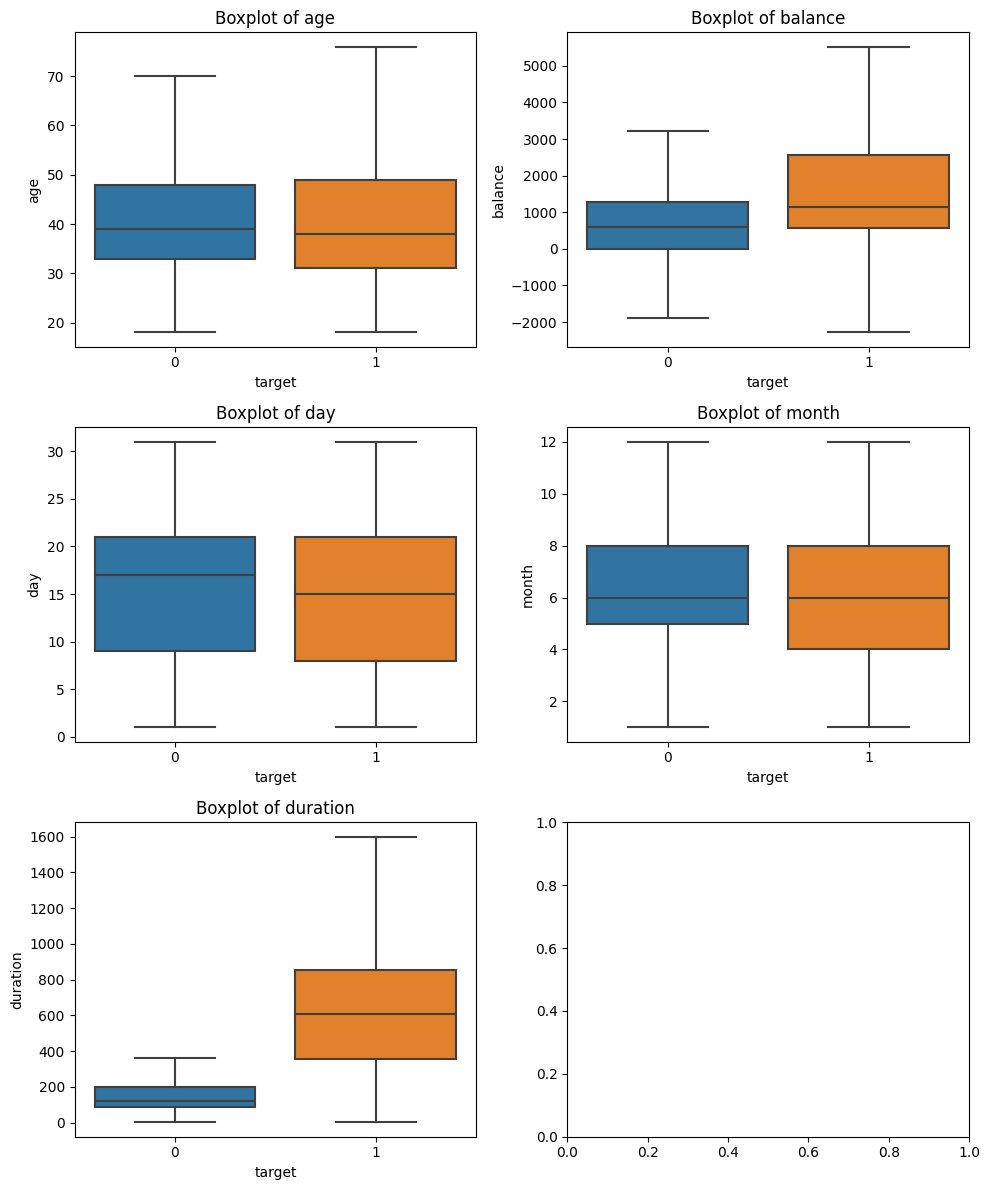

In [ ]:
# Lets check the distribution of features
features = ['age', 'balance', 'day', 'month', 'duration']
n_rows = 3
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 12))

for i, feature in enumerate(features):
    row, col = divmod(i, n_cols)
    sns.boxplot(x='y', y=feature, data=df_train, ax=axes[row, col], showfliers=False)
    axes[row, col].set_title(f"Boxplot of {feature}")
    axes[row, col].set_xlabel("target")
    axes[row, col].set_ylabel(feature)

plt.tight_layout()
plt.show()

##### Duration and balance have relatively high influence on target variable

##### Lets check the relationship between categorical features and the target

In [ ]:
categorical_features = df_train.select_dtypes(include='object')

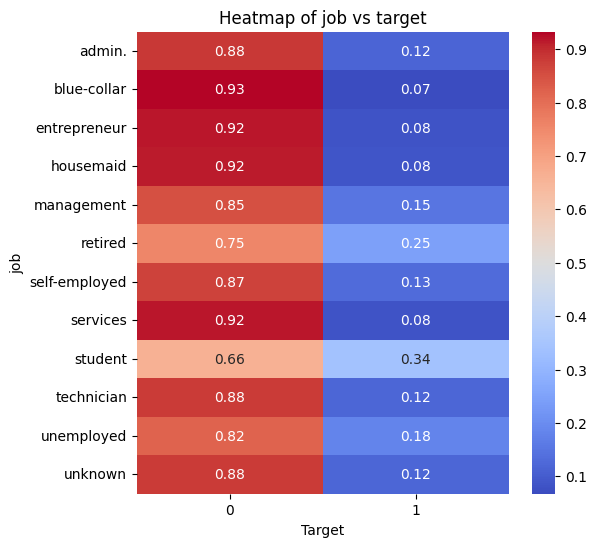

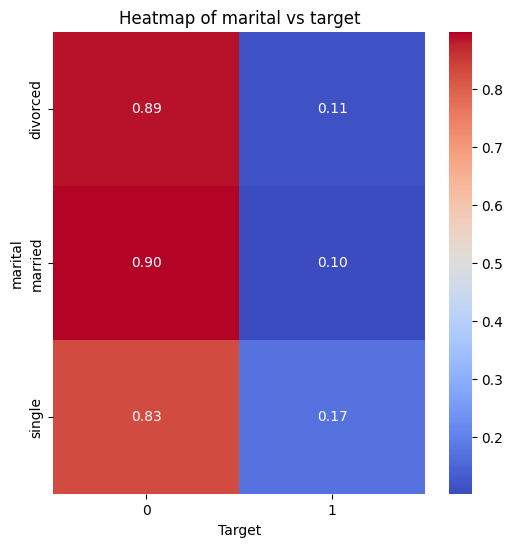

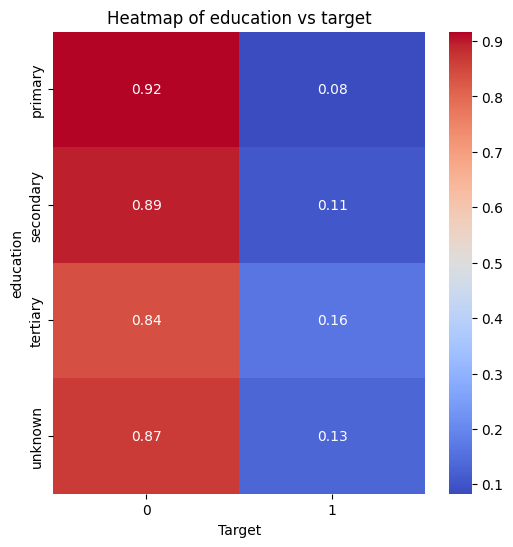

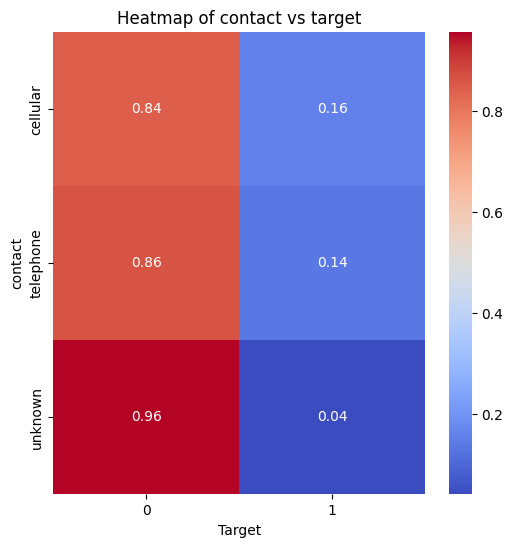

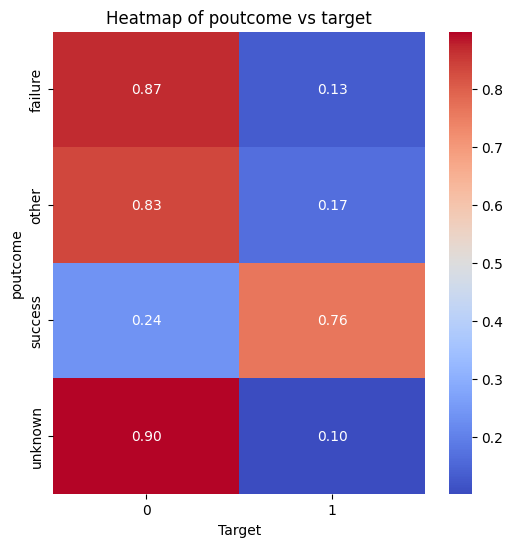

In [ ]:
for feature in categorical_features:
    plt.figure(figsize=(6,6))
    crosstab = pd.crosstab(df_train[feature], df_train['y'], normalize='index')
    sns.heatmap(crosstab,annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Heatmap of {feature} vs target')
    plt.ylabel(feature)
    plt.xlabel('Target')
    plt.show()

##### Students and Retired have 34% and 25% positive rate which is quite indicative. When it comes to the feature of poutcome(previous campaign outcome), we can see that success category has a high positive rate of 76%.

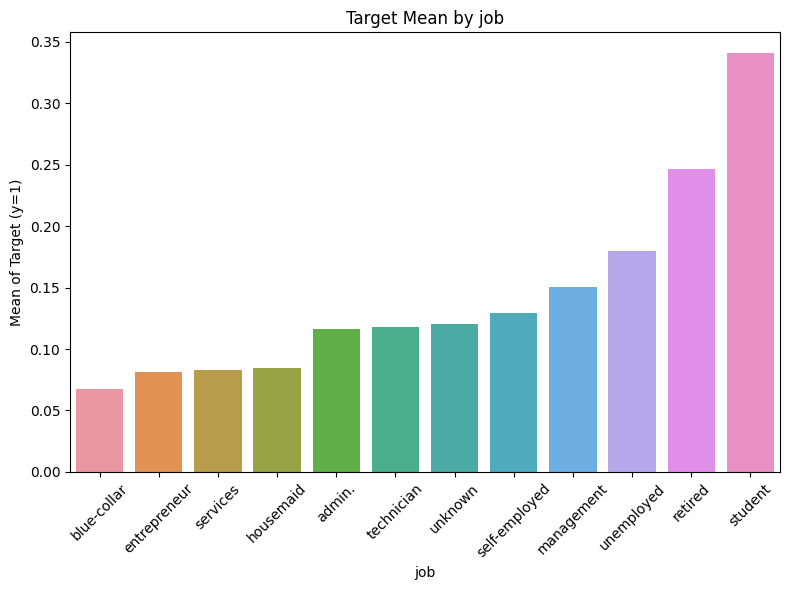

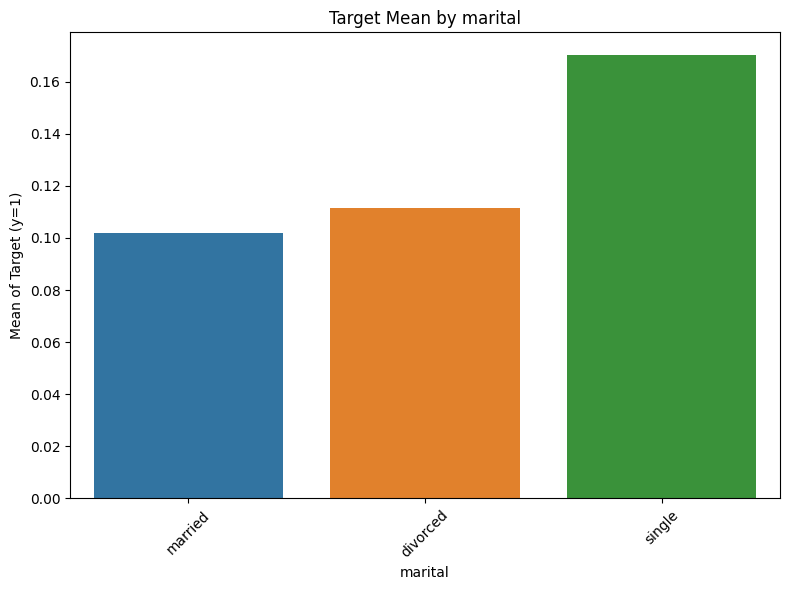

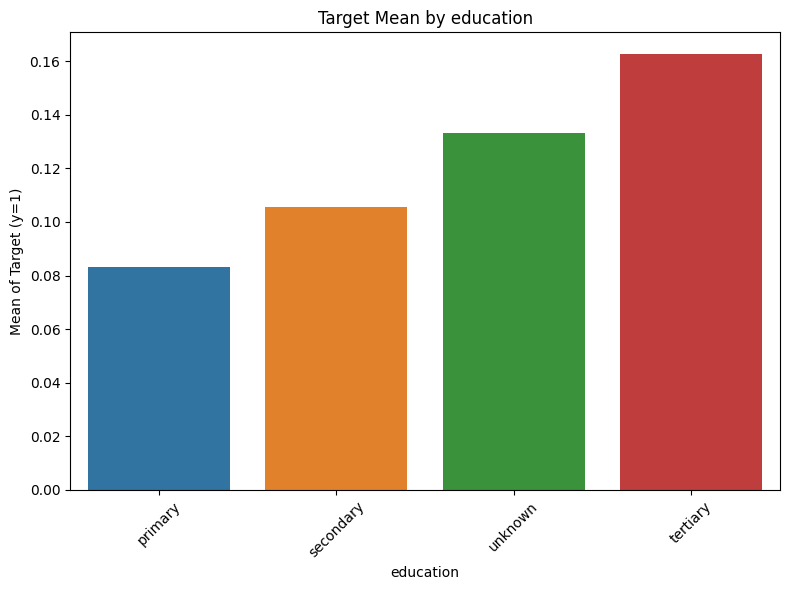

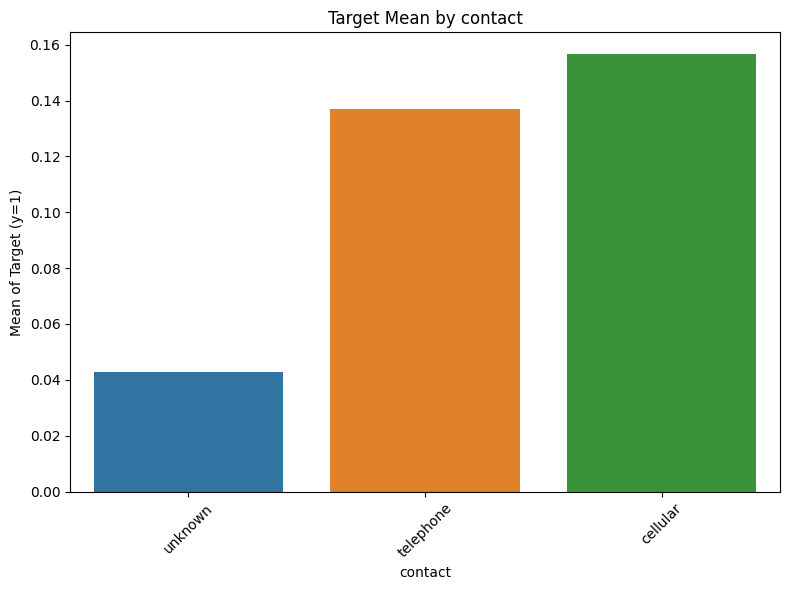

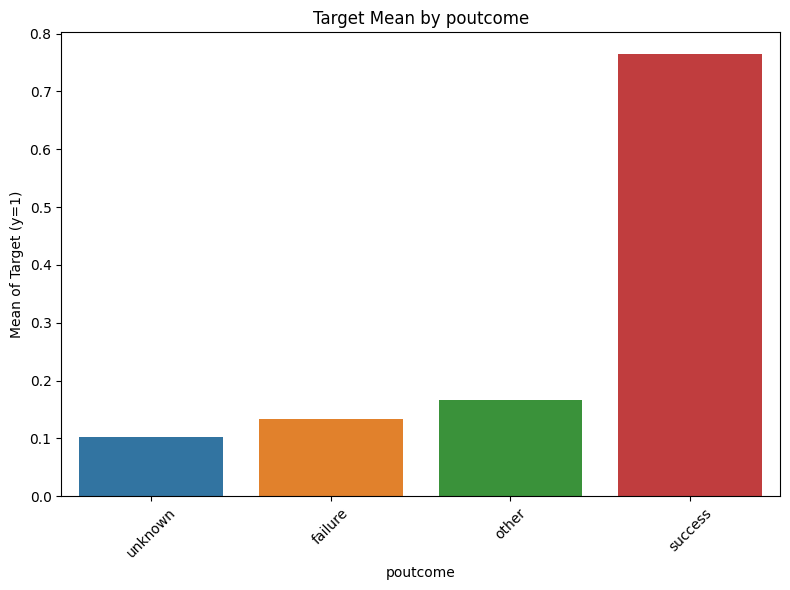

In [ ]:
# building a target mean plot
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    target_mean = df_train.groupby(feature)['y'].mean().sort_values()

    sns.barplot(x=target_mean.index, y=target_mean.values)
    plt.xticks(rotation=45)
    plt.ylabel('Mean of Target (y=1)')
    plt.title(f'Target Mean by {feature}')
    plt.tight_layout()
    plt.show()

#### Job, contact and poutcome have high variation in target mean, meaning they are potentially good predictors of target. I will use them for target encoding

### Feature engineering

In [ ]:
df_train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,0,7,0,0,cellular,25,8,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,0,514,0,0,unknown,18,6,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,0,602,1,0,unknown,14,5,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,0,34,1,0,unknown,28,5,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,0,889,1,0,cellular,3,2,902,1,-1,0,unknown,1


In [ ]:
# defining a function for creating new interaction features
def new_features(df):
    # Using duration, one the strongest predictor for feature creation
    df['duration_per_campaign'] = df['duration'] / (df['campaign'] + 1) # +1 for avoiding division by zero
    df['duration_log'] = np.log1p(df['duration'])
    df['duration_sqrt'] = np.sqrt(df['duration'])
    df['campaign_intensity'] = df['campaign'] * df['duration']

    # if the customer was contacted before
    df['was_contacted_before'] = (df['pdays'] != -1).astype(int)

    # contact fatigue feature logged
    df['contact_fatigue'] = np.log1p(df['previous'] + df['campaign'])

    # financial burrden
    df['financial_burden_score'] = ((df['balance'] < 0).astype(int) + df['loan'] + df['housing'] + df['default'])


    # Age grouping
    df['age_group'] = pd.cut(df['age'], bins=[18, 30, 45, 60, 75, 95], labels = ['Early_adult', 'Adult', 'Mature', 'Senior', 'Elder'], right=False)

    # Balance grouping
    def categorize_balance(balance):
        if balance < 0:
            return 'Debt'
        elif balance == 0:
            return 'Zero'
        elif balance <= 5000:
            return 'Low'
        elif balance <= 15000:
            return 'Moderate'
        elif balance <= 35000:
            return 'High'
        elif balance <= 70000:
            return 'Very High'
        else:
            return 'Wealthy'

    df['balance_group'] = df['balance'].apply(categorize_balance)

    # Duration grouping
    df['duration_group'] = pd.cut(df['duration'], bins=[1, 60, 180, 360, 900, 5000], labels=['very_short', 'short', 'medium', 'long', 'very_long'], right=False)

    # Interaction feature of duration and age_group
    df['duration_age_interaction'] = df['duration_group'].astype(str) + "_" + df['age_group'].astype(str)

    # balance and duration interaction
    df['balance_duration_interaction'] = df['balance_group'].astype(str) + "_" + df['duration_group'].astype(str)

    #new customer vs duration rate interaction
    df['newcomer_duration_group'] = (df['pdays'] == -1).astype(str) + "_" + df['duration_group'].astype(str)

    # half of the month
    df['month_half'] = np.where(df['day'] <= 15, 'first_half', 'last_half')

    return df

In [ ]:
# applying the function for creating new features
df_train_fe = new_features(df_train)

In [ ]:
# dropping id column
df_train_fe = df_train_fe.drop(columns='id')

In [ ]:
# Defining features i want to use for target encoding(stong predictors)
target_encode_features = ['job', 'poutcome', 'contact', 'age_group', 'balance_group',
                          'duration_group', 'duration_age_interaction', 'balance_duration_interaction',
                          'newcomer_duration_group', 'month_half']

In [ ]:
df_encoded = df_train_fe.copy()

In [ ]:
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = df_encoded[col].astype('category')

In [ ]:
categorical_cols = df_encoded.select_dtypes(include='category').columns

In [ ]:
# Label encoding categorical features, creating new ones form them. Some of categoricals we will need in target encoding
for col in categorical_cols:
    df_encoded[col + '_LE'] = LabelEncoder().fit_transform(df_encoded[col])

In [ ]:
# dropping categorical features that will not be target encoded
cols_to_drop = [col for col in categorical_cols if col not in target_encode_features]
df_encoded.drop(columns=cols_to_drop, inplace=True)

In [ ]:
# splitting the data into train and val sets
X = df_encoded.drop(columns = ['y'])
y = df_encoded['y']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# Define a funcion for target encoding
def validation_target_encoding(X, y, cat_col, m_smooth=10, n_splits=5, random_state=42):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_preds = np.zeros(len(X))
    auc = []
    f1 = []
    accuracy = []
    precision = []
    recall = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
        print(f"\n---- Fold number {fold} ----")

        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Target encoding
        encoder = MEstimateEncoder(cols=cat_col, m=m_smooth)
        encoder.fit(X_train, y_train)
        X_train_encoded = encoder.transform(X_train)
        X_val_encoded = encoder.transform(X_val)


        # Train a base model for future overfitting evaluation
        model = XGBClassifier(random_state = random_state)
        model.fit(X_train_encoded, y_train)

        # Prediction and evaluation
        preds = model.predict(X_val_encoded)
        pred_proba = model.predict_proba(X_val_encoded)[:,1]

        oof_preds[val_idx] = pred_proba

        fold_auc = roc_auc_score(y_val, pred_proba)
        fold_accuracy = accuracy_score(y_val, preds)
        fold_recall = recall_score(y_val, preds)
        fold_f1 = f1_score(y_val, preds)
        fold_precision = precision_score(y_val, preds)
        auc.append(fold_auc)
        accuracy.append(fold_accuracy)
        recall.append(fold_recall)
        f1.append(fold_f1)
        precision.append(fold_precision)
        print(f"Fold {fold} AUC: {fold_auc:.4f}")
        print(f"Fold {fold} accuracy: {fold_accuracy:.4f}")
        print(f"Fold {fold} recall: {fold_recall:.4f}")
        print(f"Fold {fold} f1: {fold_f1:.4f}")
        print(f"Fold {fold} precision: {fold_precision:.4f}")

    oof_binary = (oof_preds > 0.5).astype(int)

    print("\n-----Cross-Validation Fold Metrics (Mean ± Std)-----")
    print(f"\nMean AUC: {np.mean(auc):.4f} ± {np.std(auc):.4f}")
    print(f"\nMean Acuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}")
    print(f"\nMean Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}")
    print(f"\nMean F1: {np.mean(f1):.4f} ± {np.std(f1):.4f}")
    print(f"\nMean Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}")


    print("\n-------Out-of-Fold (OOF) Metrics------")
    print(f"OOF AUC: {roc_auc_score(y, oof_preds)}")
    print(f"OOF Accuracy: {accuracy_score(y, oof_binary)}")
    print(f"OOF Recall: {recall_score(y, oof_binary)}")
    print(f"OOF F1 Score: {f1_score(y, oof_binary)}")
    print(f"OOF Precision: {precision_score(y, oof_binary)}")

In [ ]:
%%time
validation_target_encoding(X_train, y_train, target_encode_features, m_smooth=1, n_splits=5, random_state=42)


---- Fold number 1 ----
Fold 1 AUC: 0.9661
Fold 1 accuracy: 0.9349
Fold 1 recall: 0.6688
Fold 1 f1: 0.7126
Fold 1 precision: 0.7625

---- Fold number 2 ----
Fold 2 AUC: 0.9660
Fold 2 accuracy: 0.9346
Fold 2 recall: 0.6675
Fold 2 f1: 0.7113
Fold 2 precision: 0.7613

---- Fold number 3 ----
Fold 3 AUC: 0.9661
Fold 3 accuracy: 0.9349
Fold 3 recall: 0.6689
Fold 3 f1: 0.7125
Fold 3 precision: 0.7623

---- Fold number 4 ----
Fold 4 AUC: 0.9657
Fold 4 accuracy: 0.9342
Fold 4 recall: 0.6692
Fold 4 f1: 0.7104
Fold 4 precision: 0.7570

---- Fold number 5 ----
Fold 5 AUC: 0.9673
Fold 5 accuracy: 0.9359
Fold 5 recall: 0.6721
Fold 5 f1: 0.7168
Fold 5 precision: 0.7679

-----Cross-Validation Fold Metrics (Mean ± Std)-----

Mean AUC: 0.9663 ± 0.0006

Mean Acuracy: 0.9349 ± 0.0006

Mean Recall: 0.6693 ± 0.0015

Mean F1: 0.7127 ± 0.0022

Mean Precision: 0.7622 ± 0.0035

-------Out-of-Fold (OOF) Metrics------
OOF AUC: 0.9662496996295546
OOF Accuracy: 0.9349028571428571
OOF Recall: 0.66928736067696
OOF 

##### Despite trusting category-level statistics more heavily(m_smooth=1), the model remained highly stable, with minimal variance across folds and near-identical OOF metrics. The fact that m_smooth = 1 did not introduce instability suggests that the dataset's categorical features are well-populated, with few or no rare categories. This means the category-level target means are reliable and not overly noisy. We can use target encoding without fear of overfitting

In [ ]:
# Lets apply target encoding
encoder = MEstimateEncoder(cols=target_encode_features, m=1)
encoder.fit(X_train, y_train)
X_train_encoded = encoder.transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [ ]:
# Creating an optuna objective function for optimizing the model
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2 , 0.8, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 0.8, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True)
    }

    # Cross-validation
    kf = StratifiedKFold(n_splits = 4, shuffle=True, random_state=42)
    f1_scores, precision_scores, recall_scores, accuracy_scores, roc_auc_scores = [], [], [], [], []

    for train_idx, val_idx in kf.split(X_train_encoded, y_train):
        X_train_cv, X_val_cv = X_train_encoded.iloc[train_idx], X_train_encoded.iloc[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]


        # For early stopping implementation we need to split the set further(fro validation set)
        X_train_early_stop, X_val_early_stop, y_train_early_stop, y_val_early_stop = train_test_split(
            X_train_cv, y_train_cv, test_size=0.2, stratify=y_train_cv, random_state=42
        )

        model = XGBClassifier(
            **params,
            random_state=42,
            n_jobs=-1,
            eval_metric='auc',
            early_stopping_rounds=50,
        )
        model.fit(
            X_train_early_stop, y_train_early_stop,
            eval_set=[(X_val_early_stop, y_val_early_stop)],
            verbose=False
        )

        preds = model.predict(X_val_cv)
        probas = model.predict_proba(X_val_cv)[:, 1]

        f1_scores.append(f1_score(y_val_cv, preds))
        precision_scores.append(precision_score(y_val_cv, preds))
        recall_scores.append(recall_score(y_val_cv, preds))
        accuracy_scores.append(accuracy_score(y_val_cv, preds))
        roc_auc_scores.append(roc_auc_score(y_val_cv, probas))

    # Log metrics for analysis
    trial.set_user_attr("f1", np.mean(f1_scores))
    trial.set_user_attr("precision", np.mean(precision_scores))
    trial.set_user_attr("recall", np.mean(recall_scores))
    trial.set_user_attr("accuracy", np.mean(accuracy_scores))
    trial.set_user_attr("roc_auc", np.mean(roc_auc_scores))

    # Return the metric you want to optimize
    return np.mean(roc_auc_scores)

In [ ]:
%%time
study = optuna.create_study(direction='maximize')  # ROC AUC is a metric to maximize
study.optimize(objective_xgb, n_trials=30)

[I 2025-09-03 13:25:58,009] A new study created in memory with name: no-name-b8187215-ca80-4aaa-8829-571108d91e89
[I 2025-09-03 13:28:47,045] Trial 0 finished with value: 0.9631604245366935 and parameters: {'n_estimators': 684, 'max_depth': 5, 'colsample_bytree': 0.2939252890138632, 'subsample': 0.2721119469059496, 'learning_rate': 0.025731015348602043}. Best is trial 0 with value: 0.9631604245366935.
[I 2025-09-03 13:31:32,350] Trial 1 finished with value: 0.9635407110257056 and parameters: {'n_estimators': 442, 'max_depth': 11, 'colsample_bytree': 0.2248818630703719, 'subsample': 0.26018566925502823, 'learning_rate': 0.013613513394131221}. Best is trial 1 with value: 0.9635407110257056.
[I 2025-09-03 13:32:55,150] Trial 2 finished with value: 0.964557979224792 and parameters: {'n_estimators': 304, 'max_depth': 6, 'colsample_bytree': 0.40185139193362635, 'subsample': 0.31073325528134615, 'learning_rate': 0.05817672905599679}. Best is trial 2 with value: 0.964557979224792.
[I 2025-09-0

CPU times: user 4h 54min 41s, sys: 38.3 s, total: 4h 55min 19s
Wall time: 1h 16min 38s


In [ ]:
results_XGB = {
    'Model': 'XGB_optuna_best',
    "Accuracy": study.best_trial.user_attrs["accuracy"],
    "Precision": study.best_trial.user_attrs["precision"],
    "Recall": study.best_trial.user_attrs["recall"],
    "F1 Score": study.best_trial.user_attrs["f1"],
    "ROC AUC": study.best_trial.user_attrs["roc_auc"]
}

In [ ]:
results_XGB = pd.DataFrame([results_XGB])

In [ ]:
results_XGB

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGB_optuna_best,0.936004,0.764866,0.678018,0.718827,0.967072


#### Now, lets use the best parameters to train a final model

In [ ]:
best_trial = study.best_trial
best_parameters = best_trial.params
print("Best Parameters:", best_parameters)

Best Parameters: {'n_estimators': 421, 'max_depth': 9, 'colsample_bytree': 0.535500201571739, 'subsample': 0.7921356365602319, 'learning_rate': 0.049379215760093596}


In [ ]:
final_model = XGBClassifier(**best_parameters, random_state=42, n_jobs=-1)
final_model.fit(X_train_encoded, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.535500201571739, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.049379215760093596,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=421, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

#### Lets see how our model can perform on unseen data(our validation set)

In [ ]:
val_pred = final_model.predict(X_val_encoded)
val_pred_probability = final_model.predict_proba(X_val_encoded)[:,1]
results_XGB_val = {
    "AUC": roc_auc_score(y_val, val_pred_probability),
    "F1": f1_score(y_val, val_pred),
    "Precision": precision_score(y_val, val_pred),
    "Recall": recall_score(y_val, val_pred),
    "Accuracy": accuracy_score(y_val, val_pred)
}

results_XGB_val = pd.DataFrame([results_XGB_val])

In [ ]:
results_XGB_val

,AUC,F1,Precision,Recall,Accuracy
0,0.967791,0.717873,0.765025,0.676195,0.935876


#### Results are consistant, therefore there is no sign of over and underfitting. Now we need to aply all the preprocessing steps to our test set, retrain the model on the whole data(train + validation) and make a prediction.

In [ ]:
df_test = test.copy()

In [ ]:
# data cleaning
df_test = data_cleaning(df_test)

In [ ]:
df_test = new_features(df_test)

In [ ]:
df_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,was_contacted_before,contact_fatigue,financial_burden_score,age_group,balance_group,duration_group,duration_age_interaction,balance_duration_interaction,newcomer_duration_group,month_half
0,32,blue-collar,married,secondary,0,1397,1,0,unknown,21,...,0,0.693147,1,Adult,Low,medium,medium_Adult,Low_medium,True_medium,last_half
1,44,management,married,tertiary,0,23,1,0,cellular,3,...,0,1.098612,1,Adult,Low,long,long_Adult,Low_long,True_long,first_half
2,36,self-employed,married,primary,0,46,1,1,cellular,13,...,0,1.098612,2,Adult,Low,short,short_Adult,Low_short,True_short,first_half
3,58,blue-collar,married,secondary,0,-1380,1,1,unknown,29,...,0,0.693147,3,Mature,Debt,short,short_Mature,Debt_short,True_short,last_half
4,28,technician,single,secondary,0,1950,1,0,cellular,22,...,0,0.693147,1,Early_adult,Low,medium,medium_Early_adult,Low_medium,True_medium,last_half


In [ ]:
for col in df_test.select_dtypes(include='object').columns:
    df_test[col] = df_test[col].astype('category')

In [ ]:
# Label encoding categorical features
for col in categorical_cols:
    df_test[col + '_LE'] = LabelEncoder().fit_transform(df_test[col])

In [ ]:
# dropping categorical features that will not be target encoded
cols_to_drop = [col for col in categorical_cols if col not in target_encode_features]
df_test.drop(columns=cols_to_drop, inplace=True)

In [ ]:
# Applying the learned statistics from target encoding to test set
X_test_encoded = encoder.transform(df_test)

##### Combining train and val sets for training the final model

In [ ]:
X_full = pd.concat([X_train_encoded, X_val_encoded], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)

In [ ]:
print(X_full.shape)
print(X_test_encoded.shape)

(750000, 40)
(250000, 40)


In [ ]:
# making prediction
final_model.fit(X_full, y_full)
probability = final_model.predict_proba(X_test_encoded)[:, 1]

In [ ]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['y'] = probability
submission.to_csv('submission.csv', index=False)
submission.head()

,id,y
0,750000,0.001702
1,750001,0.128330
2,750002,0.000376
3,750003,0.000082
4,750004,0.017842


In [ ]:
import joblib

In [ ]:
# Save trained model
joblib.dump(final_model, "/kaggle/working/final_model.pkl")

# Save Optuna study
joblib.dump(study, "/kaggle/working/optuna_study.pkl")

['/kaggle/working/optuna_study.pkl']